Below we will show an example of:
* Heston simulation
* Heston vs Black-Scholes pricing
* A mispricing trading strategy
* PnL and plots

After this script we will move onto a real-world scenario using stock data

=== Initial pricing comparison (t = 0) ===
S0                 : 100.00
K, T               : 100.00, 1.00 year
r                  : 0.0200
sigma_mkt (BS vol) : 0.2000
Heston MC price    : 8.3904
Black–Scholes price: 8.9160
Relative mispricing: -5.90%

=== Backtest summary ===
Horizon        : 1.00 years
Initial spot   : 100.00
Final spot     : 115.18
Initial value  : 0.0000
Final value    : 1.8768
Total PnL      : 1.8768


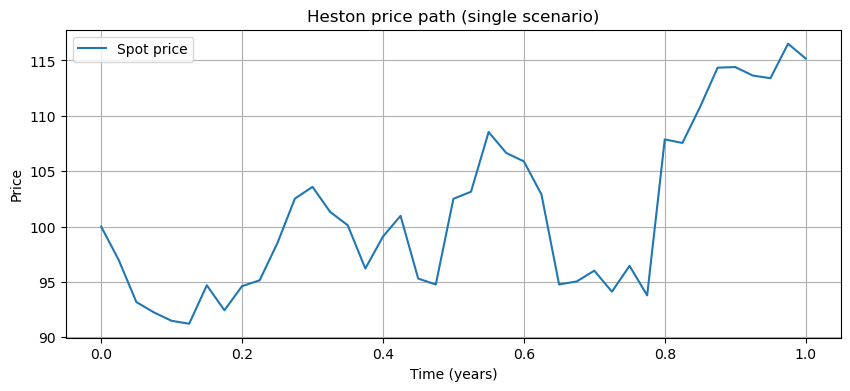

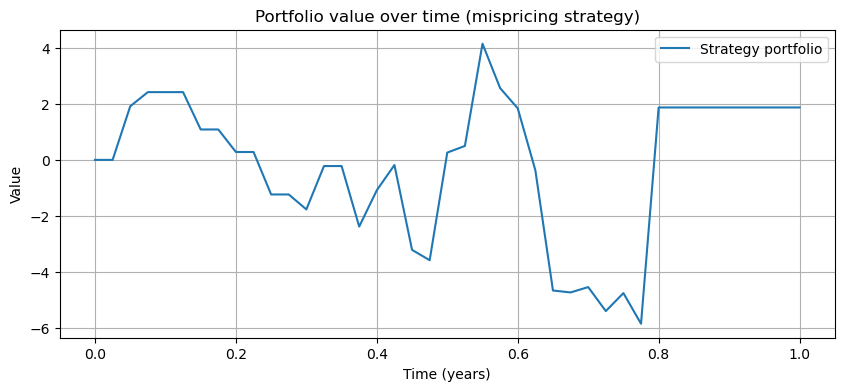

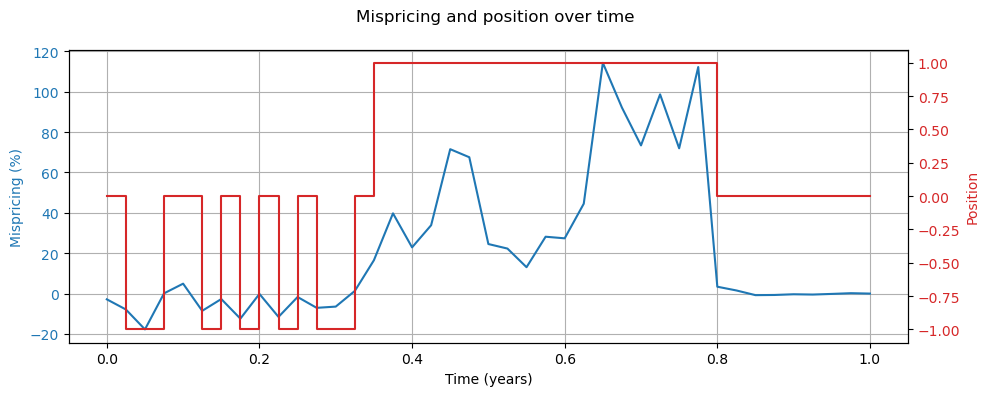

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


# ======================
# 1. PARAMETERS
# ======================

@dataclass
class HestonParams:
    kappa: float   # mean-reversion speed of variance
    theta: float   # long-run variance
    sigma: float   # vol-of-vol
    rho: float     # correlation between price and variance Brownian motions
    v0: float      # initial variance
    r: float       # risk-free rate


@dataclass
class OptionParams:
    K: float       # strike
    T: float       # maturity in years


# ======================
# 2. SIMULATION
# ======================

def simulate_heston_paths(
    S0: float,
    params: HestonParams,
    T: float,
    n_steps: int,
    n_paths: int,
    seed: int | None = None,
):
    """
    Simulate Heston price and variance paths using full-truncation Euler.
    Returns times, S_paths, v_paths.
    """
    rng = np.random.default_rng(seed)

    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)

    kappa = params.kappa
    theta = params.theta
    sigma = params.sigma
    rho = params.rho
    v0 = params.v0
    r = params.r

    times = np.linspace(0.0, T, n_steps + 1)

    S_paths = np.empty((n_paths, n_steps + 1), dtype=float)
    v_paths = np.empty((n_paths, n_steps + 1), dtype=float)

    S_paths[:, 0] = S0
    v_paths[:, 0] = v0

    for t in range(n_steps):
        Z1 = rng.standard_normal(size=n_paths)
        Z_perp = rng.standard_normal(size=n_paths)
        Z2 = rho * Z1 + np.sqrt(1.0 - rho**2) * Z_perp

        v_prev = v_paths[:, t]
        S_prev = S_paths[:, t]

        v_pos = np.maximum(v_prev, 0.0)

        v_next = (
            v_prev
            + kappa * (theta - v_pos) * dt
            + sigma * np.sqrt(v_pos) * sqrt_dt * Z2
        )
        v_next = np.maximum(v_next, 0.0)

        S_next = S_prev * np.exp(
            (r - 0.5 * v_pos) * dt + np.sqrt(v_pos) * sqrt_dt * Z1
        )

        v_paths[:, t + 1] = v_next
        S_paths[:, t + 1] = S_next

    return times, S_paths, v_paths


# ======================
# 3. PRICING
# ======================

def norm_cdf(x):
    """Standard normal CDF."""
    from math import erf, sqrt
    x = np.asarray(x, dtype=float)
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))


def black_scholes_call(S0: float, option: OptionParams, r: float, sigma: float) -> float:
    """Black–Scholes European call price."""
    from math import log, sqrt, exp

    K = option.K
    T = option.T

    if T <= 0.0 or sigma <= 0.0:
        return max(S0 - K, 0.0)

    sqrtT = sqrt(T)
    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    Nd1 = norm_cdf(d1)
    Nd2 = norm_cdf(d2)

    return S0 * Nd1 - K * exp(-r * T) * Nd2


def price_european_call_heston_mc(
    S0: float,
    option: OptionParams,
    params: HestonParams,
    n_steps: int = 200,
    n_paths: int = 50_000,
    seed: int | None = None,
) -> float:
    """
    Monte Carlo Heston price for a European call.
    """
    _, S_paths, _ = simulate_heston_paths(
        S0=S0,
        params=params,
        T=option.T,
        n_steps=n_steps,
        n_paths=n_paths,
        seed=seed,
    )
    ST = S_paths[:, -1]
    payoff = np.maximum(ST - option.K, 0.0)
    discount_factor = np.exp(-params.r * option.T)
    return float(discount_factor * np.mean(payoff))


# ======================
# 4. STRATEGY: MISPRICING
# ======================

def compute_mispricing(
    S: float,
    v: float,
    option: OptionParams,
    params: HestonParams,
    sigma_mkt: float,
    mc_steps: int = 80,
    mc_paths: int = 5_000,
    seed: int | None = None,
):
    """
    Compute Heston vs Black–Scholes mispricing from state (S, v).
    Returns (C_heston, C_bs, mispricing).
    """
    local_params = HestonParams(
        kappa=params.kappa,
        theta=params.theta,
        sigma=params.sigma,
        rho=params.rho,
        v0=v,
        r=params.r,
    )

    C_heston = price_european_call_heston_mc(
        S0=S,
        option=option,
        params=local_params,
        n_steps=mc_steps,
        n_paths=mc_paths,
        seed=seed,
    )

    C_bs = black_scholes_call(
        S0=S,
        option=option,
        r=params.r,
        sigma=sigma_mkt,
    )

    if C_bs <= 0.0:
        mispricing = 0.0
    else:
        mispricing = (C_heston - C_bs) / C_bs

    return C_heston, C_bs, mispricing


def generate_signal(mispricing: float, rel_threshold: float) -> str:
    """
    Turn mispricing into buy/sell/hold.
    """
    if mispricing > rel_threshold:
        return "buy"
    if mispricing < -rel_threshold:
        return "sell"
    return "hold"


def run_mispricing_strategy_backtest(
    S0: float,
    option: OptionParams,
    params: HestonParams,
    sigma_mkt: float,
    rel_threshold: float = 0.05,
    n_steps_path: int = 40,
    seed_path: int | None = 42,
    mc_steps_per_node: int = 40,
    mc_paths_per_node: int = 3_000,
):
    """
    Run mispricing-based strategy along a single Heston path.
    Returns a dict with times, S, v, prices, positions, portfolio_values, etc.
    """
    T = option.T

    rng_path = np.random.default_rng(seed_path)
    times, S_paths, v_paths = simulate_heston_paths(
        S0=S0,
        params=params,
        T=T,
        n_steps=n_steps_path,
        n_paths=1,
        seed=None,  # we use rng_path inside simulate if we modify it, but here it's ok
    )
    S = S_paths[0]
    v = v_paths[0]

    n_points = n_steps_path + 1

    bs_prices = np.zeros(n_points)
    heston_prices = np.zeros(n_points)
    mispricings = np.zeros(n_points)
    signals_int = np.zeros(n_points, dtype=int)
    positions = np.zeros(n_points, dtype=int)
    portfolio_values = np.zeros(n_points)

    cash = 0.0
    pos = 0

    for i, t in enumerate(times):
        tau = max(option.T - t, 0.0)
        option_t = OptionParams(K=option.K, T=tau)

        C_heston, C_bs, m = compute_mispricing(
            S=S[i],
            v=v[i],
            option=option_t,
            params=params,
            sigma_mkt=sigma_mkt,
            mc_steps=mc_steps_per_node,
            mc_paths=mc_paths_per_node,
            seed=1234 + i,  # different seed per node
        )

        heston_prices[i] = C_heston
        bs_prices[i] = C_bs
        mispricings[i] = m

        sig = generate_signal(m, rel_threshold)
        if sig == "buy":
            target_pos = 1
            signals_int[i] = 1
        elif sig == "sell":
            target_pos = -1
            signals_int[i] = -1
        else:
            target_pos = 0
            signals_int[i] = 0

        # Trade to target at BS price
        delta = target_pos - pos
        if delta != 0:
            cash -= delta * C_bs  # buy (delta>0) → pay cash; sell → receive cash
            pos = target_pos

        positions[i] = pos
        portfolio_values[i] = cash + pos * C_bs

    return {
        "times": times,
        "S": S,
        "v": v,
        "bs_prices": bs_prices,
        "heston_prices": heston_prices,
        "mispricings": mispricings,
        "signals": signals_int,
        "positions": positions,
        "portfolio_values": portfolio_values,
    }


# ======================
# 5. RUN A DEMO
# ======================

# Model & option
params = HestonParams(
    kappa=2.0,
    theta=0.04,   # long-run variance (~20% vol)
    sigma=0.5,
    rho=-0.7,
    v0=0.04,
    r=0.02,
)
S0 = 100.0
option = OptionParams(K=100.0, T=1.0)

# Market vol (Black–Scholes view)
sigma_mkt = float(np.sqrt(params.theta))

# Initial pricing comparison
C_heston_0 = price_european_call_heston_mc(
    S0=S0,
    option=option,
    params=params,
    n_steps=200,
    n_paths=30_000,
    seed=123,
)
C_bs_0 = black_scholes_call(S0, option, r=params.r, sigma=sigma_mkt)

print("=== Initial pricing comparison (t = 0) ===")
print(f"S0                 : {S0:.2f}")
print(f"K, T               : {option.K:.2f}, {option.T:.2f} year")
print(f"r                  : {params.r:.4f}")
print(f"sigma_mkt (BS vol) : {sigma_mkt:.4f}")
print(f"Heston MC price    : {C_heston_0:.4f}")
print(f"Black–Scholes price: {C_bs_0:.4f}")
if C_bs_0 > 0:
    m0 = (C_heston_0 - C_bs_0) / C_bs_0
    print(f"Relative mispricing: {m0 * 100:.2f}%")
print()

# Run backtest
results = run_mispricing_strategy_backtest(
    S0=S0,
    option=option,
    params=params,
    sigma_mkt=sigma_mkt,
    rel_threshold=0.05,
    n_steps_path=40,
    seed_path=42,
    mc_steps_per_node=25,
    mc_paths_per_node=2_000,
)

times = results["times"]
S = results["S"]
portfolio_values = results["portfolio_values"]
positions = results["positions"]
mispricings = results["mispricings"]

print("=== Backtest summary ===")
print(f"Horizon        : {times[-1]:.2f} years")
print(f"Initial spot   : {S[0]:.2f}")
print(f"Final spot     : {S[-1]:.2f}")
print(f"Initial value  : {portfolio_values[0]:.4f}")
print(f"Final value    : {portfolio_values[-1]:.4f}")
print(f"Total PnL      : {portfolio_values[-1] - portfolio_values[0]:.4f}")

# ======================
# 6. PLOTS
# ======================

# Price path
plt.figure(figsize=(10, 4))
plt.plot(times, S, label="Spot price")
plt.title("Heston price path (single scenario)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

# Portfolio vs time
plt.figure(figsize=(10, 4))
plt.plot(times, portfolio_values, label="Strategy portfolio")
plt.title("Portfolio value over time (mispricing strategy)")
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

# Mispricing and positions
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(times, mispricings * 100, label="Mispricing (%)", color="tab:blue")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Mispricing (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.step(times, positions, where="post", label="Position", color="tab:red")
ax2.set_ylabel("Position", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("Mispricing and position over time")
fig.tight_layout()
plt.show()



Below we will show the Heston model with real-world data based on a few stocks, we will build the model first and then load the model with it's results for each stock

In [31]:
import warnings
warnings.filterwarnings("ignore")  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dataclasses import dataclass

In [33]:
# ======================
# 1. MODEL & PRICING
# ======================

@dataclass
class HestonParams:
    kappa: float   # mean-reversion speed of variance
    theta: float   # long-run variance (variance, not vol)
    sigma: float   # vol-of-vol
    rho: float     # correlation between price and variance shocks
    v0: float      # initial variance
    r: float       # risk-free rate


@dataclass
class OptionParams:
    K: float       # strike
    T: float       # time to maturity (years)


def simulate_heston_paths(
    S0: float,
    params: HestonParams,
    T: float,
    n_steps: int,
    n_paths: int,
    seed: int | None = None,
):
    """
    Simulate Heston price and variance paths using full-truncation Euler.
    Returns times, S_paths, v_paths.
    """
    rng = np.random.default_rng(seed)

    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)

    kappa = params.kappa
    theta = params.theta
    sigma = params.sigma
    rho = params.rho
    v0 = params.v0
    r = params.r

    times = np.linspace(0.0, T, n_steps + 1)
    S_paths = np.empty((n_paths, n_steps + 1))
    v_paths = np.empty((n_paths, n_steps + 1))

    S_paths[:, 0] = S0
    v_paths[:, 0] = v0

    for t in range(n_steps):
        Z1 = rng.standard_normal(size=n_paths)
        Z_perp = rng.standard_normal(size=n_paths)
        Z2 = rho * Z1 + np.sqrt(1.0 - rho**2) * Z_perp

        v_prev = v_paths[:, t]
        S_prev = S_paths[:, t]

        v_pos = np.maximum(v_prev, 0.0)

        v_next = (
            v_prev
            + kappa * (theta - v_pos) * dt
            + sigma * np.sqrt(v_pos) * sqrt_dt * Z2
        )
        v_next = np.maximum(v_next, 0.0)

        S_next = S_prev * np.exp(
            (r - 0.5 * v_pos) * dt + np.sqrt(v_pos) * sqrt_dt * Z1
        )

        v_paths[:, t + 1] = v_next
        S_paths[:, t + 1] = S_next

    return times, S_paths, v_paths


def norm_cdf(x):
    """Standard normal CDF."""
    from math import erf
    x = np.asarray(x, dtype=float)
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))


def black_scholes_call(S0: float, option: OptionParams, r: float, sigma: float) -> float:
    """Black–Scholes European call price."""
    from math import log, sqrt, exp

    K = option.K
    T = option.T

    if T <= 0.0 or sigma <= 0.0:
        return max(S0 - K, 0.0)

    sqrtT = sqrt(T)
    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    Nd1 = norm_cdf(d1)
    Nd2 = norm_cdf(d2)

    return S0 * Nd1 - K * exp(-r * T) * Nd2


def price_european_call_heston_mc(
    S0: float,
    option: OptionParams,
    params: HestonParams,
    n_steps: int = 80,
    n_paths: int = 5_000,
    seed: int | None = None,
) -> float:
    """
    Monte Carlo Heston price for a European call.
    """
    _, S_paths, _ = simulate_heston_paths(
        S0=S0,
        params=params,
        T=option.T,
        n_steps=n_steps,
        n_paths=n_paths,
        seed=seed,
    )
    ST = S_paths[:, -1]
    payoff = np.maximum(ST - option.K, 0.0)
    discount = np.exp(-params.r * option.T)
    return float(discount * np.mean(payoff))


# ======================
# 2. DATA & PARAMS
# ======================

def fetch_data_with_hist_vol(
    ticker: str,
    period: str = "3y",
    interval: str = "1d",
    window: int = 20,
) -> pd.DataFrame:
    """
    Download OHLCV data for ticker and compute rolling historical volatility.
    Returns a DataFrame with columns: Close, log_return, daily_var, hist_vol.
    """
    data = yf.download(
        ticker,
        period=period,
        interval=interval,
        auto_adjust=True,
        progress=False,
    )

    # Flatten MultiIndex columns if present
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data = data.dropna(subset=["Close"])

    # Returns & realized variance
    data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
    data["daily_var"] = data["log_return"] ** 2

    # Rolling hist vol (annualized)
    data["hist_vol"] = (
        data["log_return"]
        .rolling(window)
        .std()
        * np.sqrt(252)
    )

    data = data.dropna(subset=["hist_vol"])

    return data


def build_heston_params_from_data(
    data: pd.DataFrame,
    r: float = 0.02,
    kappa: float = 2.0,
    sigma: float = 0.5,
    rho: float = -0.7,
) -> HestonParams:
    """
    Simple moment-based choice of Heston parameters from historical volatility.
    """
    avg_var = float((data["hist_vol"] ** 2).mean())
    v0 = float((data["hist_vol"] ** 2).iloc[0])

    return HestonParams(
        kappa=kappa,
        theta=avg_var,
        sigma=sigma,
        rho=rho,
        v0=v0,
        r=r,
    )


# ======================
# 3. BACKTEST
# ======================

def run_mispricing_strategy_on_data(
    data: pd.DataFrame,
    params: HestonParams,
    maturity_days: int = 30,
    rel_threshold: float = 0.10,
    n_steps_heston: int = 60,
    n_paths_heston: int = 2000,
) -> dict:
    """
    Run Heston vs BS mispricing strategy on given data.
    Returns a dict with time series and summary stats.
    """
    dates = data.index
    prices = data["Close"].values
    sigmas_mkt = data["hist_vol"].values

    n = len(data)
    last_idx = n - maturity_days  # leave room for 30d option

    bs_prices = np.zeros(last_idx)
    heston_prices = np.zeros(last_idx)
    mispricings = np.zeros(last_idx)
    positions = np.zeros(last_idx, dtype=int)
    portfolio_values = np.zeros(last_idx)

    cash = 0.0
    pos = 0

    T_rem = maturity_days / 252.0

    for i in range(last_idx):
        S_t = prices[i]
        sigma_mkt_t = sigmas_mkt[i]
        option_t = OptionParams(K=S_t, T=T_rem)

        # Local Heston v0 set to current market variance
        local_params = HestonParams(
            kappa=params.kappa,
            theta=params.theta,
            sigma=params.sigma,
            rho=params.rho,
            v0=float(sigma_mkt_t**2),
            r=params.r,
        )

        C_heston = price_european_call_heston_mc(
            S0=S_t,
            option=option_t,
            params=local_params,
            n_steps=n_steps_heston,
            n_paths=n_paths_heston,
            seed=123 + i,
        )

        C_bs = black_scholes_call(
            S0=S_t,
            option=option_t,
            r=params.r,
            sigma=sigma_mkt_t,
        )

        heston_prices[i] = C_heston
        bs_prices[i] = C_bs

        if C_bs <= 0:
            m = 0.0
        else:
            m = (C_heston - C_bs) / C_bs

        mispricings[i] = m

        # Trading rule
        if m > rel_threshold:
            target_pos = 1
        elif m < -rel_threshold:
            target_pos = -1
            target_pos
        else:
            target_pos = 0

        delta = target_pos - pos
        if delta != 0:
            cash -= delta * C_bs  # buy -> pay cash, sell -> receive cash
            pos = target_pos

        positions[i] = pos
        portfolio_values[i] = cash + pos * C_bs

    plot_dates = dates[:last_idx]

    final_pnl = float(portfolio_values[-1])
    max_drawdown = float(portfolio_values.min())
    n_trades = int(np.sum(np.diff(positions) != 0))
    mean_mispricing = float(mispricings.mean())
    std_mispricing = float(mispricings.std())

    return {
        "dates": plot_dates,
        "prices": prices[:last_idx],
        "bs_prices": bs_prices,
        "heston_prices": heston_prices,
        "mispricings": mispricings,
        "positions": positions,
        "portfolio_values": portfolio_values,
        "final_pnl": final_pnl,
        "max_drawdown": max_drawdown,
        "n_trades": n_trades,
        "mean_mispricing": mean_mispricing,
        "std_mispricing": std_mispricing,
    }


def run_heston_bs_mispricing_for_ticker(
    ticker: str,
    period: str = "3y",
    interval: str = "1d",
    maturity_days: int = 30,
    rel_threshold: float = 0.10,
    n_steps_heston: int = 60,
    n_paths_heston: int = 2000,
) -> dict:
    """
    Convenience wrapper:
    - fetch data for ticker
    - build Heston params from that data
    - run mispricing strategy
    """
    data = fetch_data_with_hist_vol(ticker, period=period, interval=interval)
    params = build_heston_params_from_data(data)

    results = run_mispricing_strategy_on_data(
        data=data,
        params=params,
        maturity_days=maturity_days,
        rel_threshold=rel_threshold,
        n_steps_heston=n_steps_heston,
        n_paths_heston=n_paths_heston,
    )

    results["params"] = params
    results["data"] = data
    return results


# ======================
# 4. PLOTTING
# ======================

def plot_results(ticker: str, results: dict) -> None:
    """
    Plot price, portfolio value, and mispricing/position for a given ticker.
    Also prints summary stats.
    """
    dates = results["dates"]
    prices = results["prices"]
    mispricings = results["mispricings"]
    positions = results["positions"]
    portfolio_values = results["portfolio_values"]

    # 1) Underlying price
    plt.figure(figsize=(11, 4))
    plt.plot(dates, prices, label=f"{ticker} price")
    plt.title(f"{ticker} Close price over time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2) Portfolio value
    plt.figure(figsize=(11, 4))
    plt.plot(dates, portfolio_values, label="Mispricing strategy")
    plt.axhline(0.0, color="black", linewidth=1, linestyle="--")
    plt.title(f"{ticker}: Heston vs BS mispricing strategy PnL")
    plt.xlabel("Date")
    plt.ylabel("Value (P&L, starting at 0)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3) Mispricing and positions
    fig, ax1 = plt.subplots(figsize=(11, 4))

    ax1.plot(dates, mispricings * 100, label="Mispricing (%)", color="tab:blue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Mispricing (%)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.step(dates, positions, where="post", label="Position", color="tab:red")
    ax2.set_ylabel("Position (calls)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.suptitle(f"{ticker}: mispricing and position over time")
    fig.tight_layout()
    plt.show()

    # Summary
    print(f"=== {ticker} strategy summary ===")
    print(f"Final PnL         : {results['final_pnl']:.4f}")
    print(f"Approx max DD     : {results['max_drawdown']:.4f}")
    print(f"Number of trades  : {results['n_trades']}")
    print(f"Mean mispricing   : {results['mean_mispricing'] * 100:.2f}%")
    print(f"Std mispricing    : {results['std_mispricing'] * 100:.2f}%")


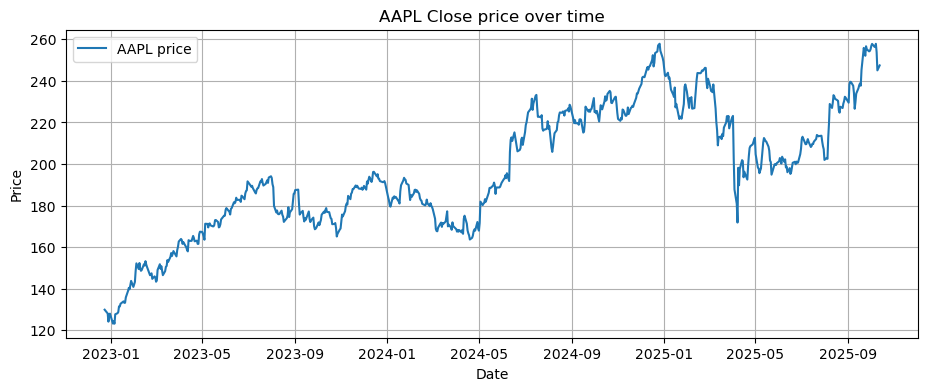

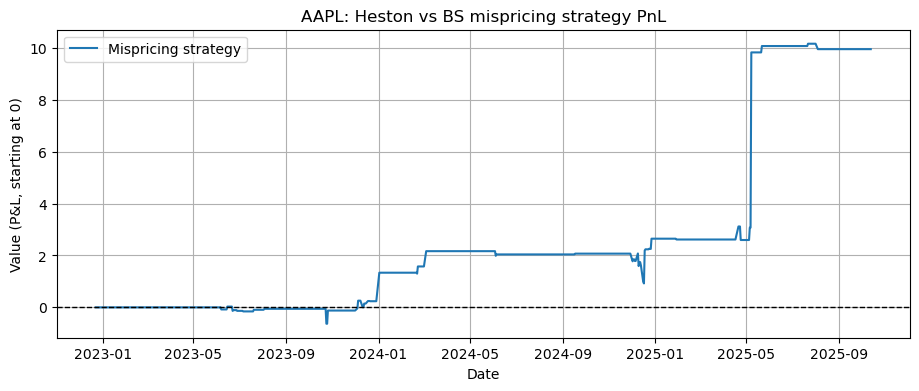

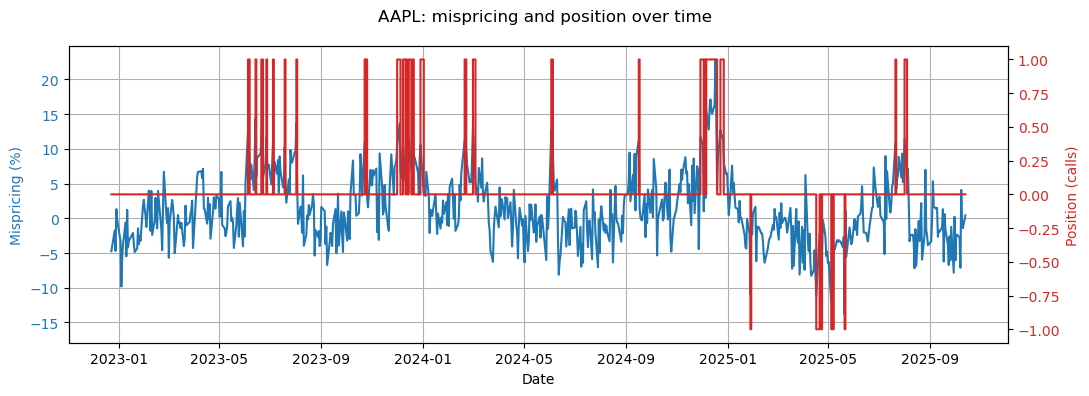

=== AAPL strategy summary ===
Final PnL         : 9.9475
Approx max DD     : -0.6297
Number of trades  : 62
Mean mispricing   : 1.32%
Std mispricing    : 5.08%


In [35]:
ticker = "AAPL"  
results_pltr = run_heston_bs_mispricing_for_ticker(ticker)
plot_results(ticker, results_pltr)


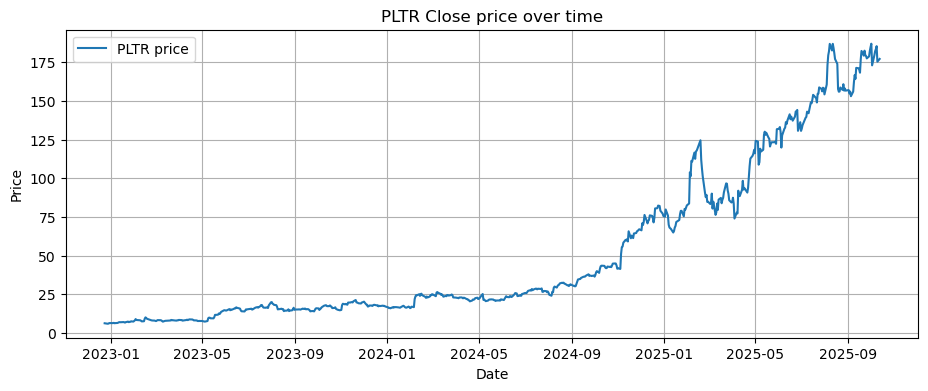

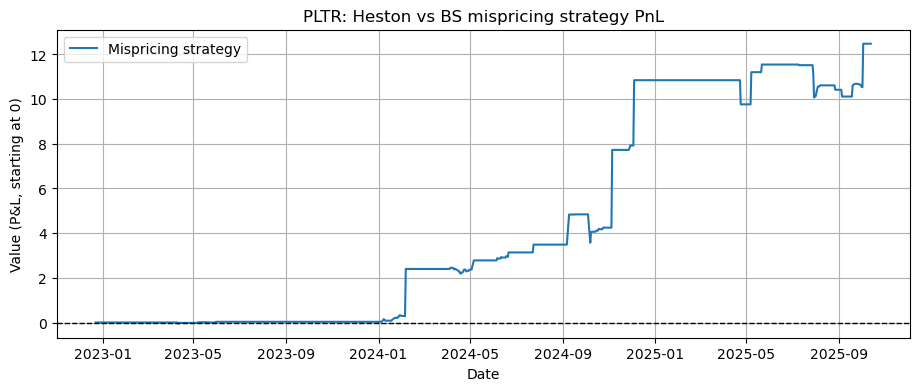

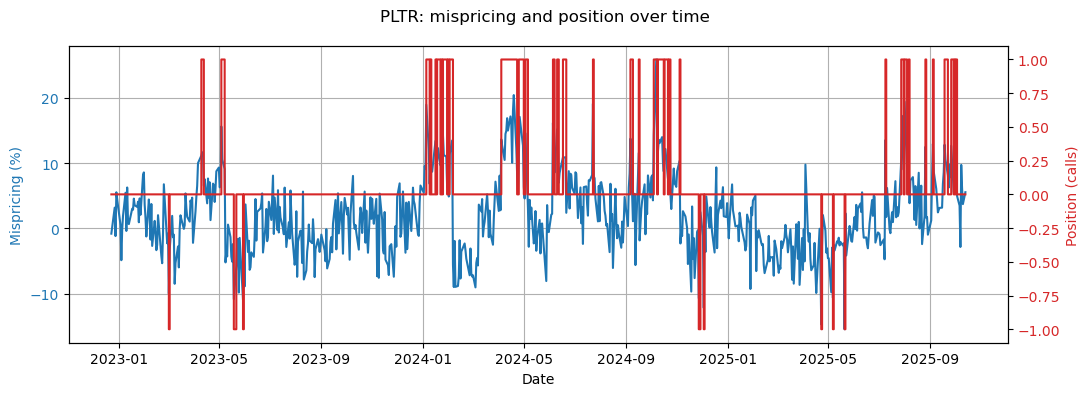

=== PLTR strategy summary ===
Final PnL         : 12.4799
Approx max DD     : -0.0543
Number of trades  : 84
Mean mispricing   : 1.98%
Std mispricing    : 5.95%


In [37]:
ticker = "PLTR"  
results_pltr = run_heston_bs_mispricing_for_ticker(ticker)
plot_results(ticker, results_pltr)


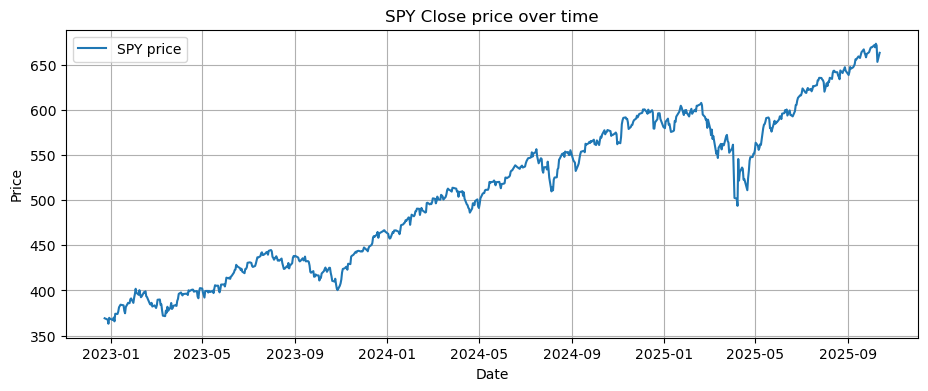

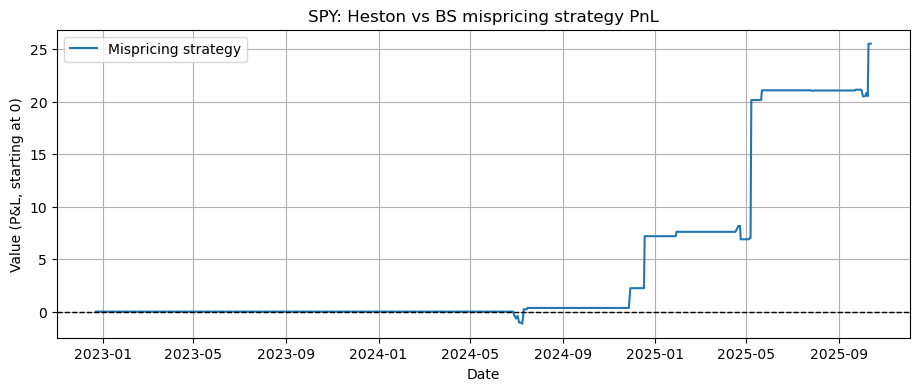

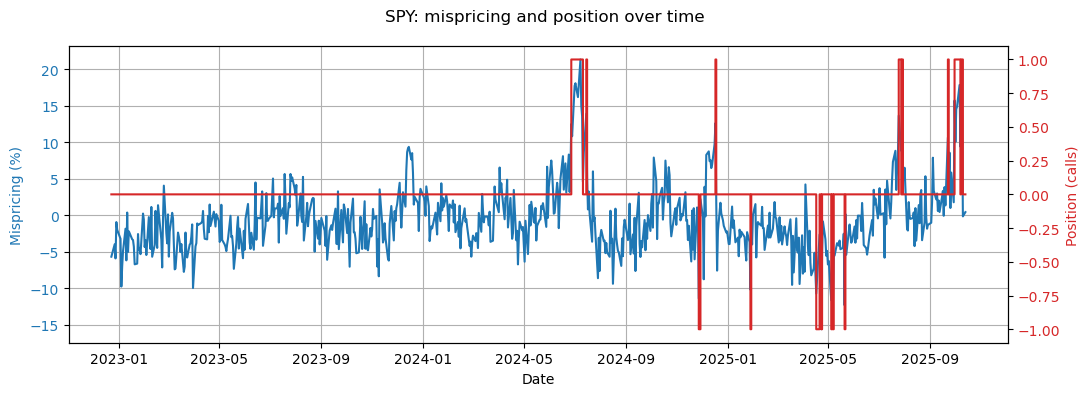

=== SPY strategy summary ===
Final PnL         : 25.5114
Approx max DD     : -1.1581
Number of trades  : 30
Mean mispricing   : -0.60%
Std mispricing    : 4.62%


In [41]:
ticker = "SPY"
results_pltr = run_heston_bs_mispricing_for_ticker(ticker)
plot_results(ticker, results_pltr)


In [ ]:
ticker = "NUE"
results_pltr = run_heston_bs_mispricing_for_ticker(ticker)
plot_results(ticker, results_pltr)
